*Christian Silva de Freitas*

Tentei usar datasets diferentes do comum, como Titanic, Iris e etc.

In [ ]:
import warnings, os, io, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import loguniform
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore")

In [ ]:
import seaborn as sns
set_style = "whitegrid"
sns.set_style(set_style)

In [ ]:
np.random.seed(42)

# Regressao - Airfoil Self-Noise

Airfoil Self-Noise, traz informações sobre o som gerado por asas de avião.
Ele mostra como variáveis como frequência, ângulo e velocidade do ar influenciam o nível de ruído produzido

In [ ]:
def load_airfoil_df(local_path=None):
    names = ["Frequency", "Angle", "Chord", "Velocity", "Thickness", "SoundPressure"]
    if local_path and os.path.exists(local_path):
        return pd.read_csv(local_path, sep=r"\s+|\t+|,", header=None, names=names, engine="python")
    urls = [
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat?download",
    ]
    for url in urls:
        try:
            df = pd.read_csv(url, sep=r"\s+|\t+|,", header=None, names=names, engine="python")
            if df.shape[1] == 6 and len(df) >= 1400:
                return df
        except Exception:
            continue
    raise RuntimeError("Deu ruim.")


In [ ]:
df = load_airfoil_df()
df.shape

(1503, 6)

A variavel a ser prevista (Y) aqui, eh a SoundPressure

In [ ]:
df.head(2)

,Frequency,Angle,Chord,Velocity,Thickness,SoundPressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Frequency      1503 non-null   int64  
 1   Angle          1503 non-null   float64
 2   Chord          1503 non-null   float64
 3   Velocity       1503 non-null   float64
 4   Thickness      1503 non-null   float64
 5   SoundPressure  1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [ ]:
df.isnull().sum()

,0
Frequency,0
Angle,0
Chord,0
Velocity,0
Thickness,0
SoundPressure,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe()

,Frequency,Angle,Chord,Velocity,Thickness,SoundPressure
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [ ]:
y = df["SoundPressure"].values
X = df.drop(columns=["SoundPressure"]).values
X_tmp, X_te, y_tmp, y_te = train_test_split(X, y, test_size=0.15, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_tmp, y_tmp, test_size=0.1764705882, random_state=42)

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(solver="sgd", batch_size=128, max_iter=500, early_stopping=True, validation_fraction=0.1, n_iter_no_change=30, random_state=42))
])

In [ ]:
topos = [(32,), (64,), (128,), (64,32), (128,64), (128,64,32)]

In [ ]:
param_dist = {
    "mlp__hidden_layer_sizes": topos,
    "mlp__activation": ["relu", "tanh"],
    "mlp__learning_rate_init": loguniform(1e-4, 3e-2),
    "mlp__momentum": [0.0, 0.5, 0.9],
    "mlp__alpha": loguniform(1e-6, 1e-2),
}

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=60, cv=cv, scoring="neg_root_mean_squared_error",
                        n_jobs=-1, refit=True, random_state=42, verbose=1)

In [ ]:
rs.fit(X_tr, y_tr)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('mlp',
                                              MLPRegressor(batch_size=128,
                                                           early_stopping=True,
                                                           max_iter=500,
                                                           n_iter_no_change=30,
                                                           random_state=42,
                                                           solver='sgd'))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'mlp__activation': ['relu', 'tanh'],
                                        'mlp__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7862f16b1640>,
                                        'mlp__hidden_layer_sizes': [(32,),
                                                                    (64,),
                                                                    (128,),
                                                                    (64, 32),
                                                                    (128, 64),
                                                                    (128, 64,
                                                                     32)],
                                        'mlp__learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7862f16b13d0>,
                                        'mlp__momentum': [0.0, 0.5, 0.9]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [ ]:
best_params = rs.best_params_
print(best_params)

{'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.00023423849847112912), 'mlp__hidden_layer_sizes': (128,), 'mlp__learning_rate_init': np.float64(0.013495117160418988), 'mlp__momentum': 0.9}


In [ ]:
best_model = rs.best_estimator_
print(best_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(activation='tanh',
                              alpha=np.float64(0.00023423849847112912),
                              batch_size=128, early_stopping=True,
                              hidden_layer_sizes=(128,),
                              learning_rate_init=np.float64(0.013495117160418988),
                              max_iter=500, n_iter_no_change=30,
                              random_state=42, solver='sgd'))])


In [ ]:
y_va_hat = best_model.predict(X_va)

In [ ]:
rmse_va = mean_squared_error(y_va, y_va_hat)
print(rmse_va)

3.901544334123256


In [ ]:
r2_va = r2_score(y_va, y_va_hat)
print(r2_va)

0.9111618129291511


In [ ]:
print("Melhores hiperparametros (selecao pela validacao):")
for k, v in best_params.items():
    print(f"{k}: {v}")
print(f"Val RMSE: {rmse_va:.4f} | Val R²: {r2_va:.4f}")

Melhores hiperparametros (selecao pela validacao):
mlp__activation: tanh
mlp__alpha: 0.00023423849847112912
mlp__hidden_layer_sizes: (128,)
mlp__learning_rate_init: 0.013495117160418988
mlp__momentum: 0.9
Val RMSE: 3.9015 | Val R²: 0.9112


In [ ]:
pipe_final = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(solver="sgd", batch_size=128, max_iter=500, early_stopping=True, validation_fraction=0.1, n_iter_no_change=30, random_state=42))
])
pipe_final.set_params(**best_params)
pipe_final.fit(np.vstack([X_tr, X_va]), np.hstack([y_tr, y_va]))
y_te_hat = pipe_final.predict(X_te)
rmse_te = mean_squared_error(y_te, y_te_hat)
r2_te = r2_score(y_te, y_te_hat)
print(f"Teste RMSE: {rmse_te:.4f} | Teste R²: {r2_te:.4f}")

Teste RMSE: 3.0590 | Teste R²: 0.9413


In [ ]:
def plot_learning_curve(estimator, X, y, title, scoring, cv):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.2, 1.0, 5), random_state=42)
    plt.figure(figsize=(7, 4.5))
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Treino')
    plt.plot(train_sizes, val_scores.mean(axis=1), marker='s', label='Val (CV)')
    plt.xlabel('Tamanho do treino')
    plt.ylabel(scoring)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def summarize_impact(cv_results_, key, top_k=20):
    df = pd.DataFrame(cv_results_).sort_values("rank_test_score").head(top_k).copy()
    df["param_val"] = df[f"param_{key}"].astype(str)
    return df.groupby("param_val")["mean_test_score"].mean().sort_values(ascending=False)

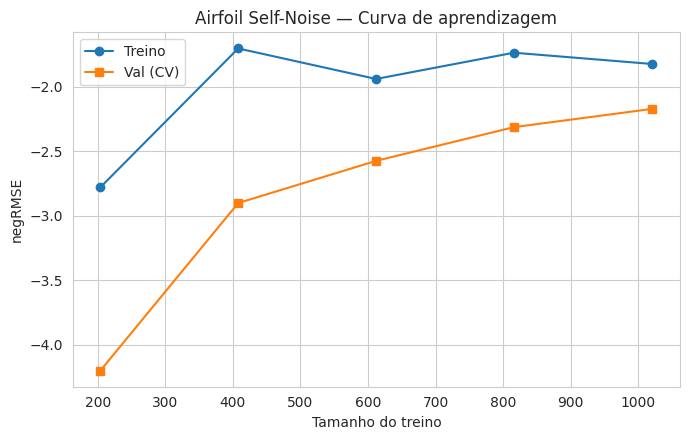

In [ ]:
sizes, tr_sc, va_sc = learning_curve(pipe_final, np.vstack([X_tr, X_va]), np.hstack([y_tr, y_va]), cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1, train_sizes=np.linspace(0.2, 1.0, 5), random_state=RANDOM_STATE)
plt.figure(figsize=(7,4.5))
plt.plot(sizes, tr_sc.mean(1), marker="o", label="Treino")
plt.plot(sizes, va_sc.mean(1), marker="s", label="Val (CV)")
plt.xlabel("Tamanho do treino"); plt.ylabel("negRMSE"); plt.title("Airfoil Self-Noise — Curva de aprendizagem"); plt.legend(); plt.tight_layout(); plt.show()

<p>O gráfico mostra que, conforme o modelo treina com mais dados, o erro diminui tanto no treino quanto na validação.</p>

<p>No começo, ele aprende pouco e tem resultados piores, mas depois as duas curvas melhoram e ficam mais próximas.</p>

<p>Isso quer dizer que o modelo está aprendendo bem e conseguindo generalizar para novos dados.</p>

<p>Ainda há espaço para melhorar um pouco se eu criar mais dados de treino.</p>

In [ ]:
cvdf = pd.DataFrame(rs.cv_results_).sort_values("rank_test_score").head(20).copy()
cvdf["momentum"] = cvdf["param_mlp__momentum"].astype(str)
cvdf["alpha"] = cvdf["param_mlp__alpha"].astype(str)
imp_momentum = cvdf.groupby("momentum")["mean_test_score"].mean().sort_values(ascending=False)
imp_alpha = cvdf.groupby("alpha")["mean_test_score"].mean().sort_values(ascending=False)
print("Impacto do momentum (media score CV nos top-20):")
print(imp_momentum)
print("\nImpacto do L2 alpha (media score CV nos top-20):")
print(imp_alpha)

Impacto do momentum (media score CV nos top-20):
momentum
0.5   -3.095789
0.9   -3.100532
0.0   -3.625490
Name: mean_test_score, dtype: float64

Impacto do L2 alpha (media score CV nos top-20):
alpha
0.00023423849847112912   -2.330564
9.074256288983866e-05    -2.356799
0.002435816505250898     -2.819542
0.005907643534563971     -2.823524
9.935023909063694e-06    -2.839530
0.001227380098785297     -2.846219
1.531418971165477e-05    -2.906087
0.0003510188772233667    -3.171495
3.6664218320637244e-05   -3.292347
0.000274319913977967     -3.305440
2.67308831078167e-05     -3.473334
0.009660837987292177     -3.493927
3.0103557686746314e-05   -3.615443
0.008584056422893501     -3.865282
2.513701074476646e-05    -3.910196
0.0003407264348530192    -3.917637
1.6480446427978994e-05   -3.975379
0.00042702329684055453   -4.040976
5.009792155498928e-06    -4.105431
6.071989493441305e-05    -4.156841
Name: mean_test_score, dtype: float64


<p>Os resultados mostram que usar momentum ajudou o modelo a ter um desempenho melhor.
Com valores de 0.5 e 0.9, o erro foi menor do que com 0.0, o que quer dizer que o treino ficou mais rápido e estável.</p>

<p>Já no caso do L2 (alpha), os melhores resultados aconteceram com valores pequenos, perto de 0.0001.
Isso mostra que uma regularização leve ajuda o modelo a aprender bem sem exagerar no ajuste dos dados.</p>

# Classificacao - Bank Marketing

Bank Marketing, vem de uma campanha de marketing de um banco em Portugal.
Ele contém dados sobre clientes e contatos realizados pelo banco, e o objetivo é prever se a pessoa aceitaria ou não uma oferta de depósito.

In [ ]:
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
!pip3 install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
bank = None
try:
    from fairlearn.datasets import fetch_bank_marketing
    Xf, yf = fetch_bank_marketing(return_X_y=True, as_frame=True)
    bank = pd.concat([Xf, yf.rename("y")], axis=1)
except Exception:
    pass
if bank is None:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional/bank-additional-full.csv"
    bank = pd.read_csv(url, sep=';')

y = bank["y"]
X = bank.drop(columns=["y"])
y = pd.factorize(y)[0]

Problema desbalanceado de classes, a classe 1 tem muito mais dados, cerca de 88% dos dados pertencem a classe 1.

In [ ]:
bank["y"].value_counts()

,count
y,
1,39922
2,5289


In [ ]:
bank["y"].value_counts(normalize=True)*100

,proportion
y,
1,88.30152
2,11.69848


In [ ]:
y

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
X.shape

(45211, 16)

In [ ]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   V1      45211 non-null  int64   
 1   V2      45211 non-null  category
 2   V3      45211 non-null  category
 3   V4      45211 non-null  category
 4   V5      45211 non-null  category
 5   V6      45211 non-null  int64   
 6   V7      45211 non-null  category
 7   V8      45211 non-null  category
 8   V9      45211 non-null  category
 9   V10     45211 non-null  int64   
 10  V11     45211 non-null  category
 11  V12     45211 non-null  int64   
 12  V13     45211 non-null  int64   
 13  V14     45211 non-null  int64   
 14  V15     45211 non-null  int64   
 15  V16     45211 non-null  category
dtypes: category(9), int64(7)
memory usage: 2.8 MB


In [ ]:
X.isnull().sum()

,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


In [ ]:
X.duplicated().sum()

np.int64(0)

In [ ]:
X.describe()

,V1,V6,V10,V12,V13,V14,V15
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
cat_cols = selector(dtype_include=["object", "category"])(X)

In [ ]:
cat_cols

['V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9', 'V11', 'V16']

In [ ]:
num_cols = selector(dtype_include=np.number)(X)
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

In [ ]:
pre

ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['V2', 'V3', 'V4', 'V5', 'V7', 'V8', 'V9',
                                  'V11', 'V16']),
                                ('num', StandardScaler(),
                                 ['V1', 'V6', 'V10', 'V12', 'V13', 'V14',
                                  'V15'])])

In [ ]:
X_tmp, X_te, y_tmp, y_te = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_tmp, y_tmp, test_size=0.1764705882, stratify=y_tmp, random_state=42)

In [ ]:
pipe = Pipeline([
    ("prep", pre),
    ("mlp", MLPClassifier(solver="sgd", batch_size=128, max_iter=500, early_stopping=True, validation_fraction=0.1, n_iter_no_change=30, random_state=42))
])

In [ ]:
topos = [(32,), (64,), (128,), (64,32), (128,64), (128,64,32)]

In [ ]:
param_dist = {
    "mlp__hidden_layer_sizes": topos,
    "mlp__activation": ["relu", "tanh"],
    "mlp__learning_rate_init": loguniform(1e-4, 3e-2),
    "mlp__momentum": [0.0, 0.5, 0.9],
    "mlp__alpha": loguniform(1e-6, 1e-2),
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=60, cv=cv, scoring="accuracy", n_jobs=-1, refit=True, random_state=42, verbose=1)

In [ ]:
rs.fit(X_tr, y_tr)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['V2',
                                                                                'V3',
                                                                                'V4',
                                                                                'V5',
                                                                                'V7',
                                                                                'V8',
                                                                                'V9',
                                                                                'V11',
                                                                                'V16']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['V1',
                                                                                'V6',
                                                                                'V10',
                                                                                'V12',
                                                                                'V13',
                                                                                'V14',
                                                                                'V15'])])),
                                             ('mlp',
                                              MLPClassifier(batch_size=128,
                                                            ear...
                   param_distributions={'mlp__activation': ['relu', 'tanh'],
                                        'mlp__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x786336246f60>,
                                        'mlp__hidden_layer_sizes': [(32,),
                                                                    (64,),
                                                                    (128,),
                                                                    (64, 32),
                                                                    (128, 64),
                                                                    (128, 64,
                                                                     32)],
                                        'mlp__learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7862ec8bd610>,
                                        'mlp__momentum': [0.0, 0.5, 0.9]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
best_params = rs.best_params_
print(best_params)

{'mlp__activation': 'relu', 'mlp__alpha': np.float64(6.242659053860567e-06), 'mlp__hidden_layer_sizes': (128,), 'mlp__learning_rate_init': np.float64(0.009064850091367628), 'mlp__momentum': 0.9}


In [ ]:
best_model = rs.best_estimator_
print(best_model)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['V2', 'V3', 'V4', 'V5', 'V7',
                                                   'V8', 'V9', 'V11', 'V16']),
                                                 ('num', StandardScaler(),
                                                  ['V1', 'V6', 'V10', 'V12',
                                                   'V13', 'V14', 'V15'])])),
                ('mlp',
                 MLPClassifier(alpha=np.float64(6.242659053860567e-06),
                               batch_size=128, early_stopping=True,
                               hidden_layer_sizes=(128,),
                               learning_rate_init=np.float64(0.009064850091367628),
                               max_iter=500, n_iter_no_change=30,
                               random_state=42, solver='sgd'))])


In [ ]:
y_va_hat = best_model.predict(X_va)

O modelo acertou 90 % das previsões, o que é muito bom.
Como o dataset é desbalanceado (ha bem mais exemplos de uma classe), essa metrica mostra que o modelo aprendeu o padrão geral dos dados, mas pode estar favorecendo a classe majoritaria

In [ ]:
acc_va = accuracy_score(y_va, y_va_hat)
acc_va

0.9040106163373636

In [ ]:
f1_va = f1_score(y_va, y_va_hat)
f1_va

0.531317494600432

In [ ]:
print("Melhores hiperparâmetros (validação):")
for k, v in best_params.items():
    print(f"{k}: {v}")
print(f"Val ACC: {acc_va:.4f} | Val F1: {f1_va:.4f}")

Melhores hiperparâmetros (validação):
mlp__activation: relu
mlp__alpha: 6.242659053860567e-06
mlp__hidden_layer_sizes: (128,)
mlp__learning_rate_init: 0.009064850091367628
mlp__momentum: 0.9
Val ACC: 0.9040 | Val F1: 0.5313


In [ ]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

Eu particularmente goosto de usar ROC AUC para avaliar tarefas de classificacao, porque mostra o quanto o modelo consegue diferenciar as classes.

Mesmo com o desbalanceamento, o modelo consegue atribuir pontuações de probabilidade bem separadas, o que é muito bom, sinal de que esta conseguindo generalizar bem.

In [ ]:
y_va_proba = best_model.predict_proba(X_va)[:, 1]
auc_va = roc_auc_score(y_va, y_va_proba)
print(f"Val ROC AUC: {auc_va:.4f}")

Val ROC AUC: 0.9155


Teste ACC: 0.9050 | Teste F1: 0.5299 | Teste ROC AUC: 0.9217


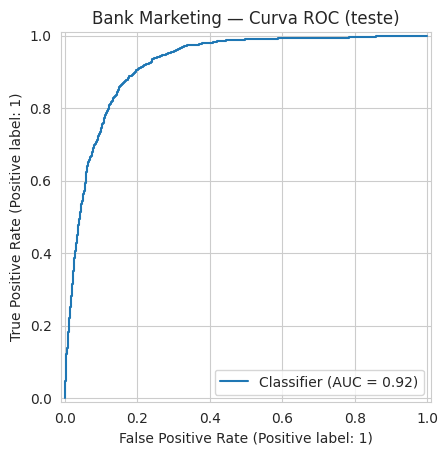

In [ ]:
pipe_final = Pipeline([
    ("prep", pre),
    ("mlp", MLPClassifier(
        solver="sgd",
        batch_size=128,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=30,
        random_state=42))
])

pipe_final.set_params(**best_params)
pipe_final.fit(pd.concat([X_tr, X_va]), np.concatenate([y_tr, y_va]))

y_te_hat = pipe_final.predict(X_te)
y_te_proba = pipe_final.predict_proba(X_te)[:, 1]

acc_te = accuracy_score(y_te, y_te_hat)
f1_te = f1_score(y_te, y_te_hat)
auc_te = roc_auc_score(y_te, y_te_proba)

print(f"Teste ACC: {acc_te:.4f} | Teste F1: {f1_te:.4f} | Teste ROC AUC: {auc_te:.4f}")

RocCurveDisplay.from_predictions(y_te, y_te_proba)
plt.title("Bank Marketing — Curva ROC (teste)")
plt.show()

<p>Quando o modelo treina com mais dados, a acurácia melhora e fica estável.
As curvas de treino e validação estão bem próximas, o que mostra que o modelo aprendeu bem e não está decorando os dados.
Depois de um certo ponto, usar mais dados quase não muda o resultado, então o modelo já está funcionando de forma equilibrada.</p>

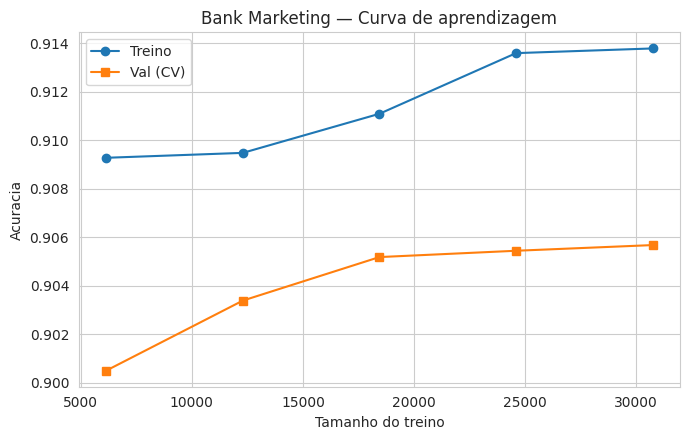

In [ ]:
sizes, tr_sc, va_sc = learning_curve(pipe_final, pd.concat([X_tr, X_va]), np.concatenate([y_tr, y_va]), cv=cv, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.2, 1.0, 5), random_state=42)
plt.figure(figsize=(7,4.5))
plt.plot(sizes, tr_sc.mean(1), marker="o", label="Treino")
plt.plot(sizes, va_sc.mean(1), marker="s", label="Val (CV)")
plt.xlabel("Tamanho do treino"); plt.ylabel("Acuracia"); plt.title("Bank Marketing — Curva de aprendizagem"); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
cvdf = pd.DataFrame(rs.cv_results_).sort_values("rank_test_score").head(20).copy()
cvdf["momentum"] = cvdf["param_mlp__momentum"].astype(str)
cvdf["alpha"] = cvdf["param_mlp__alpha"].astype(str)
imp_momentum = cvdf.groupby("momentum")["mean_test_score"].mean().sort_values(ascending=False)
imp_alpha = cvdf.groupby("alpha")["mean_test_score"].mean().sort_values(ascending=False)
print("Impacto do momentum (media score CV nos top-20):")
print(imp_momentum)
print("\nImpacto do L2 alpha (media score CV nos top-20):")
print(imp_alpha)

Impacto do momentum (media score CV nos top-20):
momentum
0.9    0.904088
0.5    0.903776
0.0    0.903551
Name: mean_test_score, dtype: float64

Impacto do L2 alpha (media score CV nos top-20):
alpha
6.242659053860567e-06     0.905394
3.735862630812757e-05     0.905362
0.0023395864551222475     0.904857
0.00023423849847112912    0.904667
3.0771802712506896e-06    0.904541
8.053471030316104e-06     0.904383
0.004997749370303174      0.904383
0.00042702329684055453    0.904383
6.338653441536265e-05     0.904351
0.002435816505250898      0.903972
1.91920011015619e-05      0.903877
0.009660837987292177      0.903403
2.3036990230378654e-06    0.903403
3.6664218320637244e-05    0.903340
0.0015352246941973493     0.903277
0.005907643534563971      0.903277
0.001227380098785297      0.903182
0.00047354909465785835    0.903056
0.000136885572763103      0.902803
8.891936446296244e-06     0.902676
Name: mean_test_score, dtype: float64


<p>Os resultados mostram que o momentum ajudou um pouco o modelo, já que valores 0.5 e 0.9 tiveram desempenho um pouco melhor do que 0.0.
Isso quer dizer que o uso de momentum deixou o treino mais rápido e estável, mas a diferença foi pequena, o que mostra que o modelo já estava bem ajustado.</p>

<p>Sobre o L2 (alpha), os melhores resultados aconteceram com valores bem pequenos, próximos de 1e-5.
Isso indica que uma regularização leve foi suficiente para evitar overfitting sem atrapalhar o aprendizado.
Valores muito grandes de L2 reduziram um pouco a acurácia, mostrando que o modelo ficou mais travado pra aprender.</p>

# Conclusao

<p>Esses testes mostraram que as redes neurais conseguiram se adaptar bem a diferentes tipos de dados.
A regularizacao ajudou o modelo a nao decorar o treino, e o uso de momentum deixou o aprendizado mais estavel.
Mesmo com resultados bons, ainda da pra melhorar o desempenho testando outros otimizadores alem do SGD, como Adam (que eh um dos unicos que conheco).
Nos proximos passos, quero comparar esses metodos para ver qual traz o melhor equilibrio entre tempo de treino e qualidade das previsoes. </p>